<a href="https://colab.research.google.com/github/poets-ai/elegy/blob/master/docs/getting-started/high-level-api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started: High-level API

In this tutorial we will explore the basic features of **Elegy**. If you are a Keras user you should feel at home, if you are currently using Jax things will appear much more streamlined. To get started you will first need to install the following dependencies:

In [ ]:
! pip install --upgrade pip
! pip install elegy dataget matplotlib
# For GPU install proper version of your CUDA, following will work in COLAB:
# ! pip install --upgrade jax jaxlib==0.1.59+cuda101 -f https://storage.googleapis.com/jax-releases/jax_releases.html

**Note:** that Elegy depends on the jax CPU version hosted on Pypi, if you want to run jax on GPU you will need to [install it](https://github.com/google/jax#installation) separately. If you are running this example on Colab, jax is already preinstalled but you can uncomment the last line of the previous cell if you want to update it.

## Loading the Data
In this tutorial we will train a Neural Network on the MNIST dataset, for this we will first need to download and load the data into memory. Here we will use `dataget` for simplicity but you can use you favorite datasets library.

In [1]:
from datasets.load import load_dataset

dataset = load_dataset("mnist")
dataset.set_format("np")
X_train = dataset["train"]["image"]
y_train = dataset["train"]["label"]
X_test = dataset["test"]["image"]
y_test = dataset["test"]["label"]

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test:", X_test.shape, X_test.dtype)
print("y_test:", y_test.shape, y_test.dtype)

Reusing dataset mnist (/home/cris/.cache/huggingface/datasets/mnist/mnist/1.0.0/5064c25e57a1678f700d2dc798ffe8a6d519405cca7d33670fffda477857a994)
100%|██████████| 2/2 [00:00<00:00, 264.93it/s]

X_train: (60000, 28, 28) uint8
y_train: (60000,) int64
X_test: (10000, 28, 28) uint8
y_test: (10000,) int64


In this case `dataget` loads the data from Yann LeCun's website.

## Defining the Architecture
The first thing we need to do is define our model's architecture, Elegy's Basic API is "framework-agnostic" in the sense that it lets you use varios popular Module systems like Flax, Haiku, Elegy, pure Jax functions, and you can give support to other Module system if you wish.

For simplicity we are going to use `elegy.Module` but the code would be very similar in e.g Flax or Haiku. To implement an Elegy Module all we have to create a class that inherits from `elegy.Module` and defines the `call` method. In this example we will create a simple 2 layer MLP using standard modules from `elegy.nn`: 

In [7]:
import jax.numpy as jnp
import jax

import elegy as eg

class MLP(eg.Module):
    """Standard LeNet-300-100 MLP network."""
    def __init__(self, n1: int = 300, n2: int = 100, **kwargs):
        super().__init__(**kwargs)
        self.n1 = n1
        self.n2 = n2
    
    @eg.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        x = x.astype(jnp.float32) / 255.0
        x = eg.nn.Flatten()(x)
        x = eg.nn.Linear(self.n1)(x)
        x = jax.nn.relu(x)
        x = eg.nn.Linear(self.n2)(x)
        x = jax.nn.relu(x)
        x = eg.nn.Linear(10)(x)
        
        return x

This code should feel familiar to most Keras / PyTorch users. The main difference here is that Jax module systems tend to use hook-based patters so you can actually declare the submodules (e.g. Linear) inline, this tends to produce much shorter and more readable code.

## Creating the Model

Now that we have this module we can create an Elegy `Model` which is Elegy's central API:

In [8]:
import optax

model = eg.Model(
    module=MLP(n1=300, n2=100),
    loss=[
        eg.losses.SparseCategoricalCrossentropy(from_logits=True),
        eg.regularizers.L2(l=1e-4),
    ],
    metrics=eg.metrics.Accuracy(),
    optimizer=optax.adam(1e-3),
)

An Elegy Model lets you train, evaluate, and perform inference but requires you to define a module, losses, metrics, and an optimizer depending on what you are doing. If you are a Keras user you should feel at home, just be aware that Elegy is a more flexible in the way it handles losses and metrics (for the better) so checkout of the guides on these to see the differences.

As in Keras, you can get a rich description of the model by calling `Model.summary` with a sample input:

In [9]:
model.summary(X_train[:64])

┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ path     ┃ module    ┃ params         ┃ inputs         ┃ outputs        ┃ Parameter       ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ *        │ MLP()     │                │ (64, 28, 28)   │ (64, 10)       │                 │
│          │           │                │ uint8          │ float32        │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│ .flatten │ Flatten() │                │ (64, 28, 28)   │ (64, 784)      │                 │
│          │           │                │ float32        │ float32        │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│ .linear  │ Linear()  │ bias:          │ (64, 784)      │ (64, 300)      │ 235,500         │
│          │           │ Parameter(300) │ float32        │ float32        │ 942.0KB         │
│          │           │ float32        │                │                │                 │
│          │           │ kernel:        │                │                │                 │
│          │           │ Parameter(784, │                │                │                 │
│          │           │ 300)  float32  │                │                │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│ .linear2 │ Linear()  │ bias:          │ (64, 300)      │ (64, 100)      │ 30,100          │
│          │           │ Parameter(100) │ float32        │ float32        │ 120.4KB         │
│          │           │ float32        │                │                │                 │
│          │           │ kernel:        │                │                │                 │
│          │           │ Parameter(300, │                │                │                 │
│          │           │ 100)  float32  │                │                │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│ .linear3 │ Linear()  │ bias:          │ (64, 100)      │ (64, 10)       │ 1,010    4.0KB  │
│          │           │ Parameter(10)  │ float32        │ float32        │                 │
│          │           │ float32        │                │                │                 │
│          │           │ kernel:        │                │                │                 │
│          │           │ Parameter(100, │                │                │                 │
│          │           │ 10)   float32  │                │                │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│          │           │                │                │         Total: │ 266,610  1.1MB  │
└──────────┴───────────┴────────────────┴────────────────┴────────────────┴─────────────────┘
                                                                                             
                              Total Parameters: 266,610  1.1MB                               

**Note:** this works on custom Flax and Haiku modules as well but you might see less details since their standard Modules don't support summaries. Check out the Basic API guides on Modules for more information.

## Training the Model
We are now ready to pass our model some data to start training, like in Keras this is done via the `fit` method which contains more or less the same signature. Elegy support a variety of input data sources like Tensorflow Dataset, Pytorch DataLoader, Elegy DataLoader, and Python Generators, check out the guide on Data Sources for more information. 

The following code will train our model for `100` epochs while limiting each epoch to `200` steps and using a batch size of `64`:

In [ ]:
history = model.fit(
    inputs=X_train,
    labels=y_train,
    epochs=100,
    steps_per_epoch=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[eg.callbacks.ModelCheckpoint("models/high-level", save_best_only=True)],
)

```
...

199/200 [============================>.] - 1s 7ms/step - accuracy: 0.9932 - l2_loss: 0.0455 - loss: 0.0682 - sparse_categorical_crossentropy_loss: 0.0227 - val_accuracy: 0.9824 - val_l2_loss: 0.0453 - val_loss: 0.1015 - val_sparse_categorical_crossentropy_loss: 0.0562
Epoch 100/100
200/200 [==============================] - 1s 7ms/step - accuracy: 0.9955 - l2_loss: 0.0451 - loss: 0.0596 - sparse_categorical_crossentropy_loss: 0.0146 - val_accuracy: 0.9804 - val_l2_loss: 0.0448 - val_loss: 0.1068 - val_sparse_categorical_crossentropy_loss: 0.0619                      
```

The `elegy.callbacks.ModelCheckpoint` callback will periodicall saves the model a folder called `"models/high-level"` during training which is very useful if we want to load it after the process is finished, we will use it later.`fit` returns a `History` object which which contains information the time series for the values of the losses and metrics throughout training, we can use it to generate some nice plots of the evolution of our training:

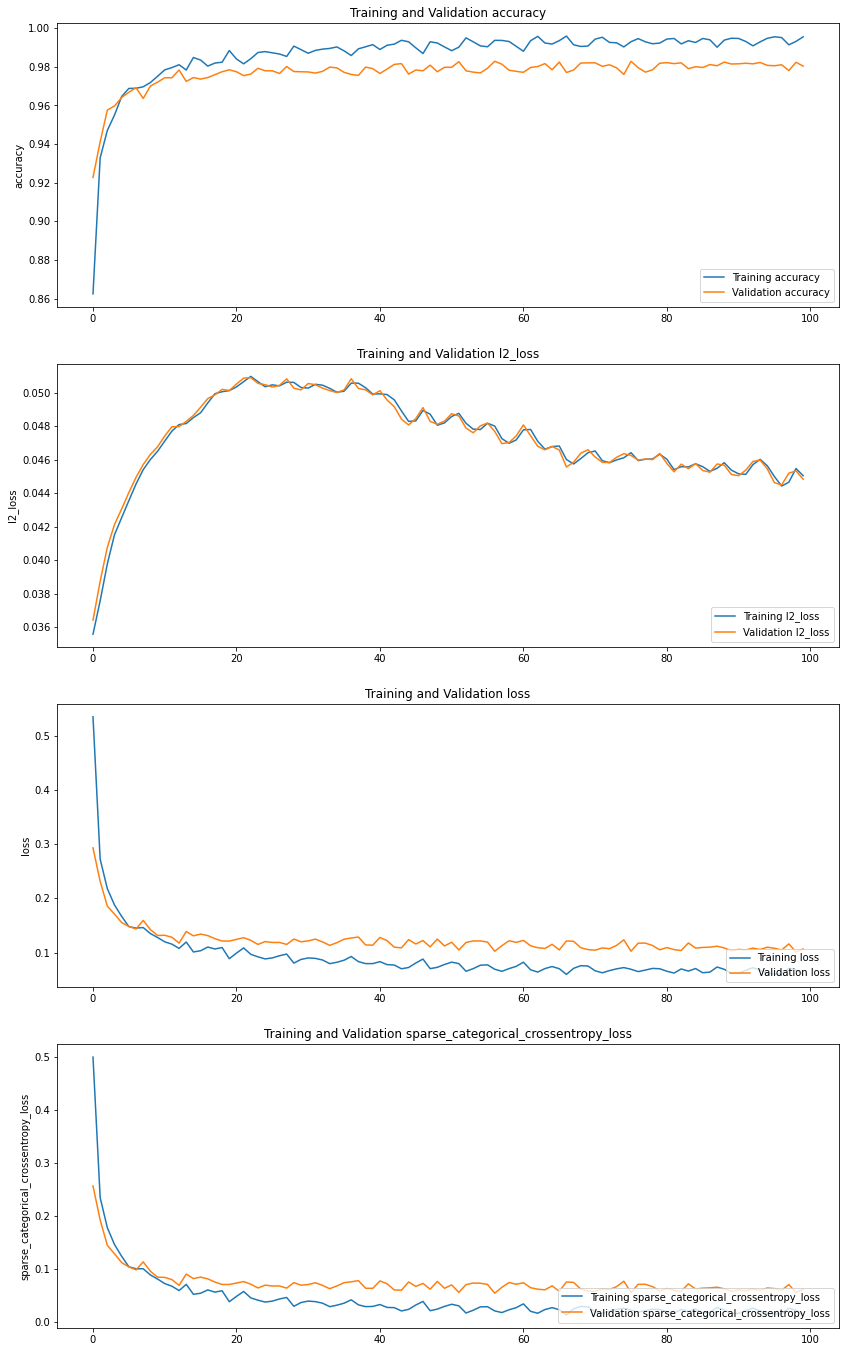

In [11]:
import matplotlib.pyplot as plt

def plot_history(history):
    n_plots = len(history.history.keys()) // 2
    plt.figure(figsize=(14, 24))
    
    for i, key in enumerate(list(history.history.keys())[:n_plots]):
        metric = history.history[key]
        val_metric = history.history[f"val_{key}"]

        plt.subplot(n_plots, 1, i + 1)
        plt.plot(metric, label=f"Training {key}")
        plt.plot(val_metric, label=f"Validation {key}")
        plt.legend(loc="lower right")
        plt.ylabel(key)
        plt.title(f"Training and Validation {key}")
    plt.show()
    
plot_history(history)

## Generating Predictions

Having our trained model we can now get some samples from the test set and generate some predictions. First we will just pick some random samples using `numpy`:

In [12]:
import numpy as np

idxs = np.random.randint(0, 10000, size=(9,))
x_sample = X_test[idxs]

Here we selected `9` random images. Now we can use the `predict` method to get their labels:

In [13]:
y_pred = model.predict(x=x_sample)

Easy right? Finally lets plot the results to see if they are accurate.

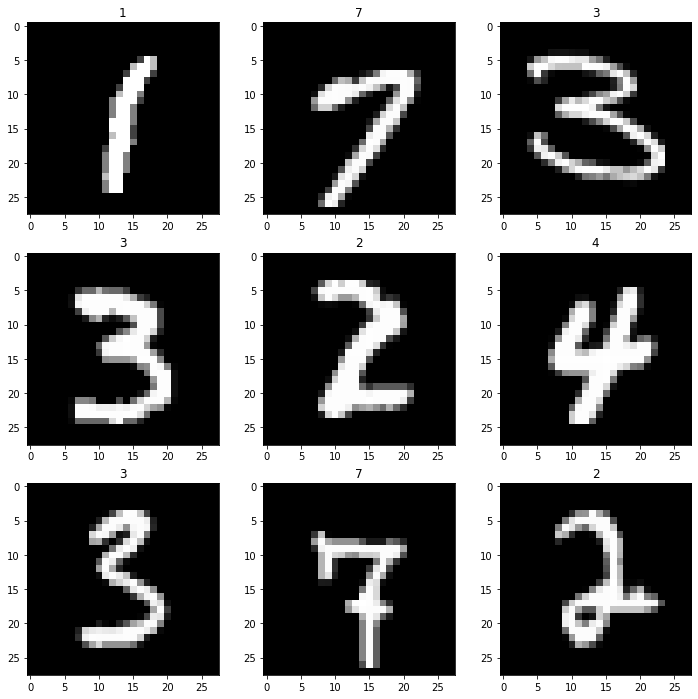

In [14]:
plt.figure(figsize=(12, 12))
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        plt.subplot(3, 3, k + 1)
    
        plt.title(f"{np.argmax(y_pred[k])}")
        plt.imshow(x_sample[k], cmap="gray")

Perfect!

## Serialization
To serialize the `Model` you can use the `model.save(...)`, this will create a folder with some files that contain the model's code plus all parameters and states, however since we had previously used the `ModelCheckpoint` callback we can load it using `elegy.load`. Lets get a new model reference containing the same weights and call its `evaluate` method to verify it loaded correctly:

In [16]:
# You can use can use `save` but `ModelCheckpoint already serialized the model
# model.save("model")

# current model reference
print("current model id:", id(model))

# load model from disk
model = eg.load("models/high-level")

# new model reference
print("new model id:    ", id(model))

# check that it works!
model.evaluate(x=X_test, y=y_test)

current model id: 140154986223936
new model id:     140153460081616
313/313 [==============================] - 4s 13ms/step - accuracy: 0.9796 - l2_loss: 0.0453 - loss: 0.1113 - sparse_categorical_crossentropy_loss: 0.0659


{'accuracy': DeviceArray(0.9824, dtype=float32),
 'l2_loss': DeviceArray(0.04534456, dtype=float32),
 'loss': DeviceArray(0.10134413, dtype=float32),
 'sparse_categorical_crossentropy_loss': DeviceArray(0.05599957, dtype=float32),
 'size': 32}

### Saved Models

You can also serialize your Elegy Model as a TensorFlow SavedModel which is portable to many platforms many platforms and services, to do this you can use the `saved_model` method. `saved_model` will convert the function that creates the predictions for your Model (`pred_step`) in Jax to a TensorFlow version via `jax2tf` and then serialize it to disk.

In [17]:
model.saved_model(x_sample, "saved-models/high-level")

INFO:tensorflow:Assets written to: saved-models/high-level/assets


INFO:tensorflow:Assets written to: saved-models/high-level/assets


As you can see`saved_model` accepts a sample to infer the shapes, the path where the model will be saved at, and a list of batch sizes for the different signatures it accepts. Due to some current limitations in Jax it is not possible to create signatures with dynamic dimensions so you must specify a couple which might fit you needs. 

We can test our saved model by loading it with TensorFlow and generating a couple of predictions as we did previously:

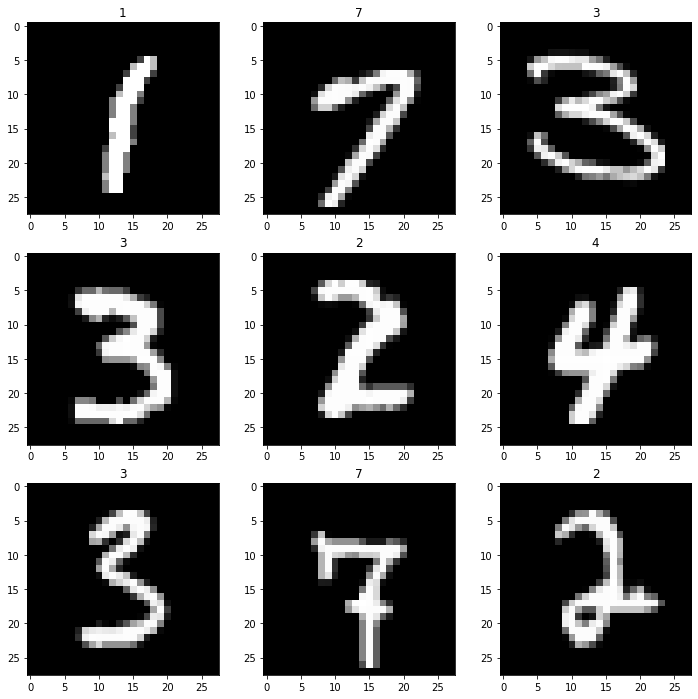

In [18]:
import tensorflow as tf

saved_model = tf.saved_model.load("saved-models/high-level")

y_pred_tf = saved_model(x_sample)

plt.figure(figsize=(12, 12))
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        plt.subplot(3, 3, k + 1)
    
        plt.title(f"{np.argmax(y_pred_tf[k])}")
        plt.imshow(x_sample[k], cmap="gray")

Excellent! We hope you've enjoyed this tutorial.

## Next Steps
Elegy is still in a very early stage, there are probably tons of bugs and missing features but we will get there. If you have some ideas or feedback on the current design we are eager to hear from you, feel free to open an issue.